In [1]:
!mamba install pandas numpy matplotlib seaborn


mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, pandas, seaborn
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 2.44539999999851 seconds
  Name                          Version                       Build                         Channel                       
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
+ pandas                        2.3.3                         np22py313h9d9dc1e_0           emscripten-forge              
+ patsy                         1.0.2                         py313h1804a44_0               emscripten-forge              
+ python-tzdata                 2025.3                        pyhd8ed1ab_0                  conda-forge                   
+ seaborn                       0.13.2                        hd8ed1ab_3                    conda-forge                   
+ seaborn-base                  0.13.2      

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
enrol_df = pd.read_csv("enrollment_final_no_duplicates.csv", encoding="latin-1")
demo_df  = pd.read_csv("demographic_final_no_duplicates.csv", encoding="latin-1")
bio_df   = pd.read_csv("biometric_final_FINAL_STANDARDIZED.csv", encoding="latin-1")

print("Data Loaded Successfully")

Data Loaded Successfully


In [4]:
for df in [enrol_df, demo_df, bio_df]:
    df['date'] = pd.to_datetime(
        df['date'],
        dayfirst=True,
        errors='coerce'
    )
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

print("Dates converted to datetime (DD-MM-YYYY)")

Dates converted to datetime (DD-MM-YYYY)


In [5]:
# --------------------------------------------
# STEP 3: AGGREGATE TO DISTRICT–MONTH LEVEL
# --------------------------------------------

# Enrolment
enrol = enrol_df.groupby(
    ['state','district','year','month']
)[['age_0_5','age_5_17','age_18_greater']].sum().reset_index()
enrol['total_enrolment'] = enrol[['age_0_5','age_5_17','age_18_greater']].sum(axis=1)

# Demographic (pick any column containing "age")
demo_age_cols = [c for c in demo_df.columns if "age" in c.lower()]
demo = demo_df.groupby(
    ['state','district','year','month']
)[demo_age_cols].sum().reset_index()
demo['total_demo_updates'] = demo[demo_age_cols].sum(axis=1)

# Biometric (pick any column containing "age")
bio_age_cols = [c for c in bio_df.columns if "age" in c.lower()]
bio = bio_df.groupby(
    ['state','district','year','month']
)[bio_age_cols].sum().reset_index()
bio['total_bio_updates'] = bio[bio_age_cols].sum(axis=1)

print("Aggregation completed using actual age columns found in files.")

# --------------------------------------------
# STEP 4: CREATE SYSTEM LOAD SIGNALS
# --------------------------------------------

# Use total columns
demo['demo_total'] = demo['total_demo_updates']
bio['bio_total'] = bio['total_bio_updates']

# --------------------------------------------
# STEP 5
# --------------------------------------------
merged = enrol.merge(
    demo,
    on=['state','district','year','month'],
    how='left'
).merge(
    bio,
    on=['state','district','year','month'],
    how='left'
)

# Fill missing values with zero
merged = merged.fillna(0)

# --------------------------------------------
# STEP 6: TOTAL UPDATE LOAD
# --------------------------------------------
merged['total_updates'] = merged['total_demo_updates'] + merged['total_bio_updates']

# --------------------------------------------
# STEP 7: SHOCK ZONE DETECTION
# --------------------------------------------
merged['z_score'] = merged.groupby('district')['total_updates'].transform(
    lambda x: (x - x.mean()) / x.std()
)
merged['shock_zone'] = merged['z_score'] > 2

# --------------------------------------------
# STEP 8: SILENT MOBILITY SIGNAL (ADULT FOCUS)
# --------------------------------------------
merged['adult_update_pressure'] = merged['total_updates']
merged['adult_enrol_change'] = merged.groupby('district')['age_18_greater'].pct_change()

# --------------------------------------------
# STEP 9: WASTED EFFORT INDEX (WEI)
# --------------------------------------------
merged['WEI'] = merged['total_updates'] / merged['total_enrolment']

# --------------------------------------------
# STEP 10: SAVE MASTER TABLE
# --------------------------------------------
merged.to_csv("aadhaar_master_analysis_final.csv", index=False)
print("Master Analysis File Saved: aadhaar_master_analysis_final.csv")


Aggregation completed using actual age columns found in files.
Master Analysis File Saved: aadhaar_master_analysis_final.csv


In [6]:
df = merged.copy()  # Use the merged dataset

master = pd.read_csv("aadhaar_master_analysis_final.csv")
print("Files loaded successfully")

# Standardize column names
for df in [enrol, demo, bio, master]:
    df.columns = df.columns.str.lower().str.strip()

# Ensure month exists
for df in [enrol, demo, bio, master]:
    if "month" not in df.columns:
        df["month"] = pd.to_datetime(df["date"], dayfirst=True).dt.month

# ---------------------------
# 2️⃣ CREATE WORKING DATAFRAME
# ---------------------------

df = master.copy()

# Create key totals if missing
df["total_updates"] = df.get("total_demo_updates", 0) + df.get("total_bio_updates", 0)
df["total_enrolment"] = df.get("total_enrolment", 1)

df["update_per_enrolment"] = df["total_updates"] / df["total_enrolment"]

# Stress (shock) zone using z-score
df["z_score"] = (df["total_updates"] - df["total_updates"].mean()) / df["total_updates"].std()
df["shock_zone"] = (df["z_score"] > 2).astype(int)

print("Master analytical dataframe ready")

Files loaded successfully
Master analytical dataframe ready


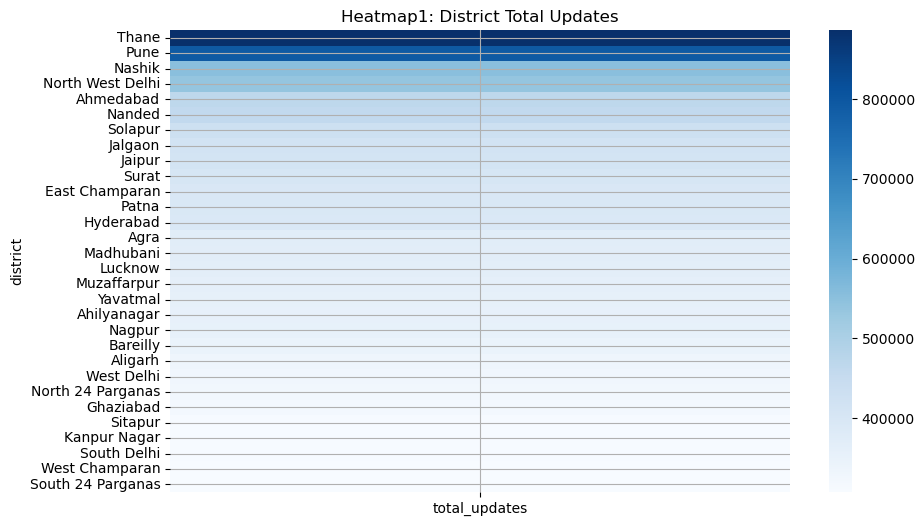

In [10]:

# ======================================================
# HEATMAPS
# ======================================================

district_updates = df.groupby("district")["total_updates"].sum().reset_index()
district_updates = district_updates.sort_values("total_updates", ascending=False).head(30)

plt.figure(figsize=(10,6))
sns.heatmap(district_updates.set_index("district"), cmap="Blues")
plt.title("Heatmap1: District Total Updates")
plt.savefig("heatmap_district_total_updates_v2.png", bbox_inches="tight")
plt.grid(True)
plt.show()

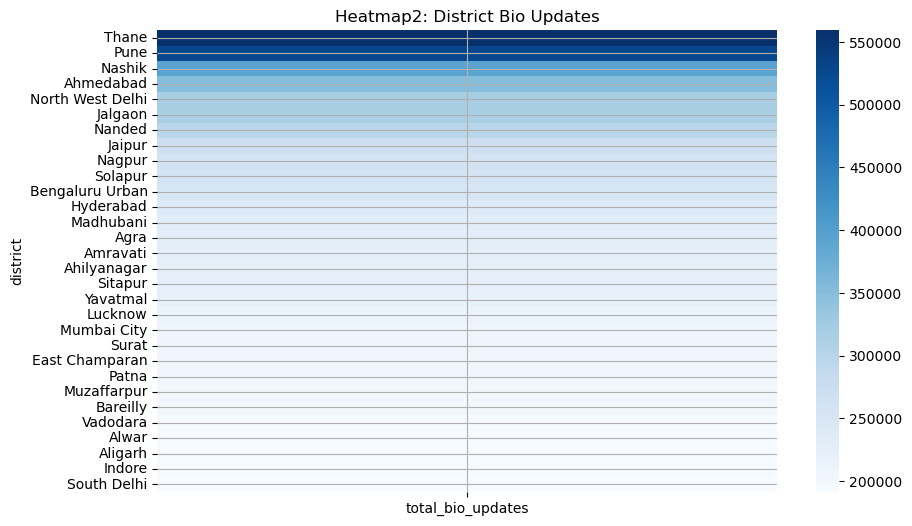

In [9]:
district_bio = df.groupby("district")["total_bio_updates"].sum().reset_index()
district_bio = district_bio.sort_values("total_bio_updates", ascending=False).head(30)

plt.figure(figsize=(10,6))
sns.heatmap(district_bio.set_index("district"), cmap="Blues")
plt.title("Heatmap2: District Bio Updates")
plt.savefig("heatmap_district_bio_updates_v2.png", bbox_inches="tight")
plt.grid(True)
plt.show()

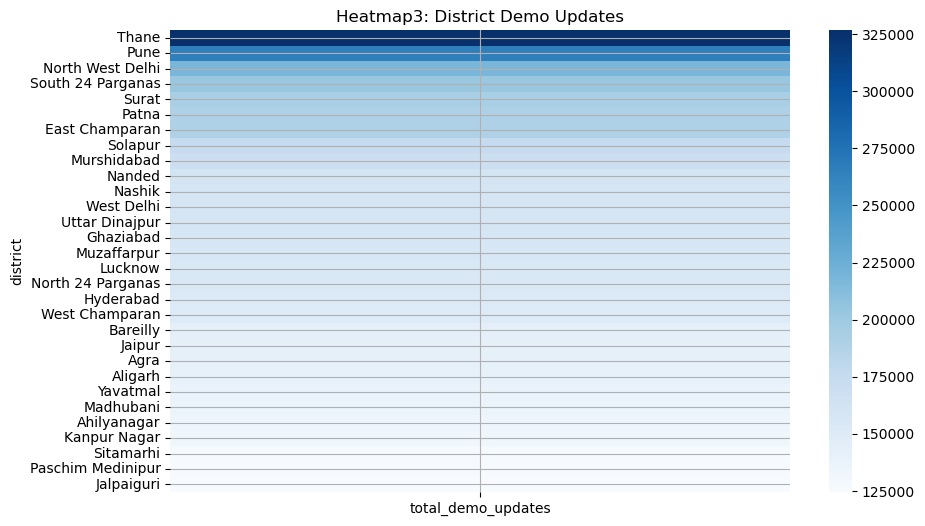

In [12]:
district_demo = df.groupby("district")["total_demo_updates"].sum().reset_index()
district_demo = district_demo.sort_values("total_demo_updates", ascending=False).head(30)

plt.figure(figsize=(10,6))
sns.heatmap(district_demo.set_index("district"), cmap="Blues")
plt.title("Heatmap3: District Demo Updates")
plt.savefig("heatmap_district_demo_updates_v2.png", bbox_inches="tight")
plt.grid(True)
plt.show()

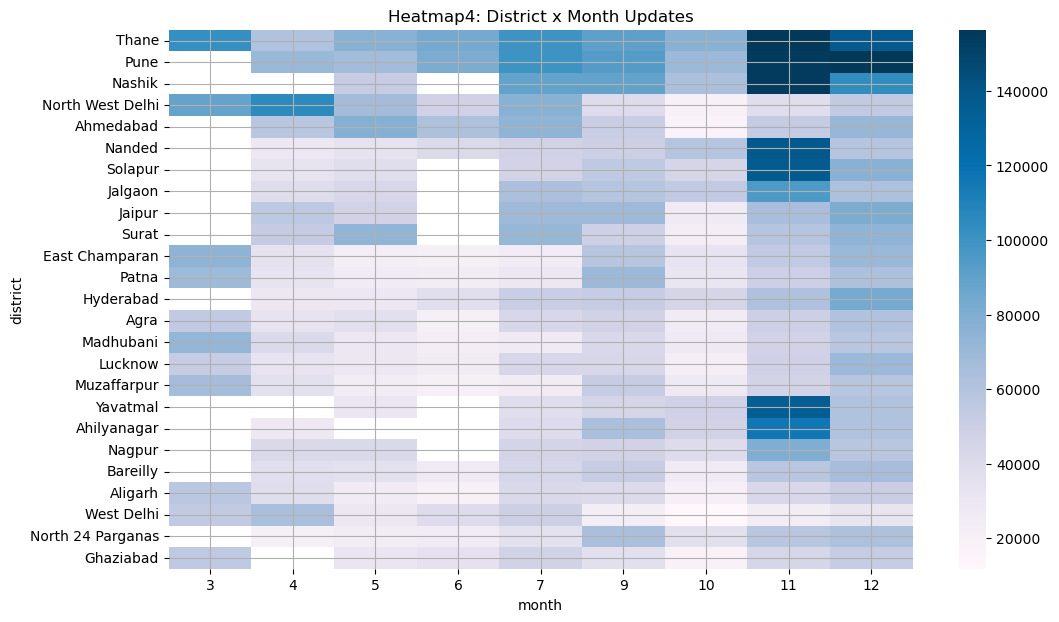

In [14]:
pivot_updates = df.pivot_table(index="district",
                               columns="month",
                               values="total_updates",
                               aggfunc="sum")

top = pivot_updates.sum(axis=1).sort_values(ascending=False).head(25).index
pivot_updates = pivot_updates.loc[top]

plt.figure(figsize=(12,7))
sns.heatmap(pivot_updates, cmap="PuBu")
plt.title("Heatmap4: District x Month Updates")
plt.savefig("heatmap_district_month_updates_v2.png", bbox_inches="tight")
plt.grid(True)
plt.show()

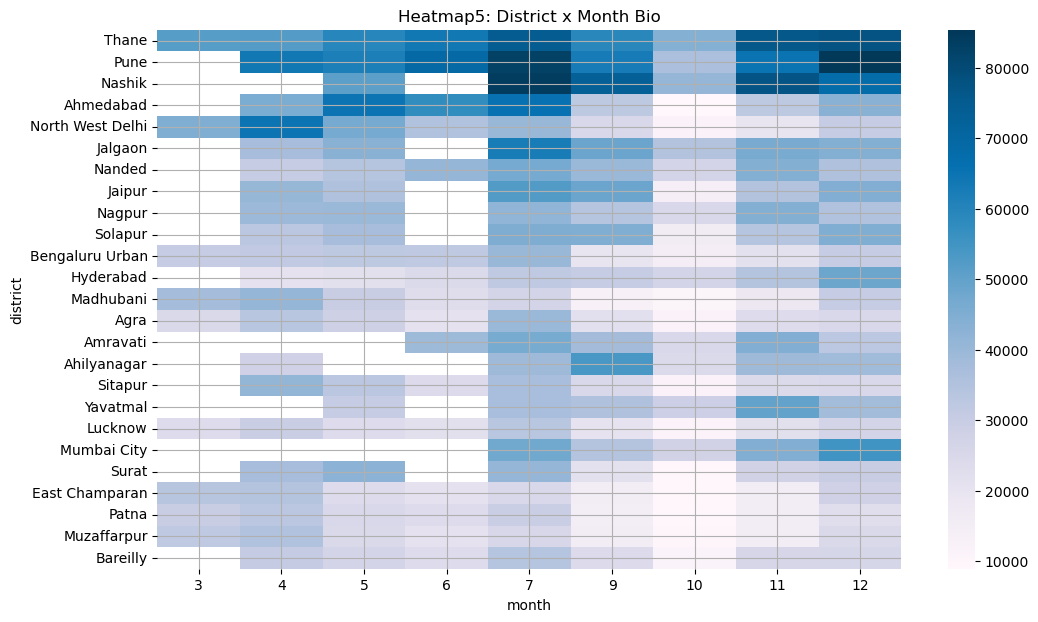

✅ ALL CHARTS GENERATED AND SAVED SUCCESSFULLY!


In [15]:
pivot_bio = df.pivot_table(index="district",
                           columns="month",
                           values="total_bio_updates",
                           aggfunc="sum")

top = pivot_bio.sum(axis=1).sort_values(ascending=False).head(25).index
pivot_bio = pivot_bio.loc[top]

plt.figure(figsize=(12,7))
sns.heatmap(pivot_bio, cmap="PuBu")
plt.title("Heatmap5: District x Month Bio")
plt.savefig("heatmap_district_month_bio_v2.png", bbox_inches="tight")
plt.grid(True)
plt.show()

print("✅ ALL CHARTS GENERATED AND SAVED SUCCESSFULLY!")

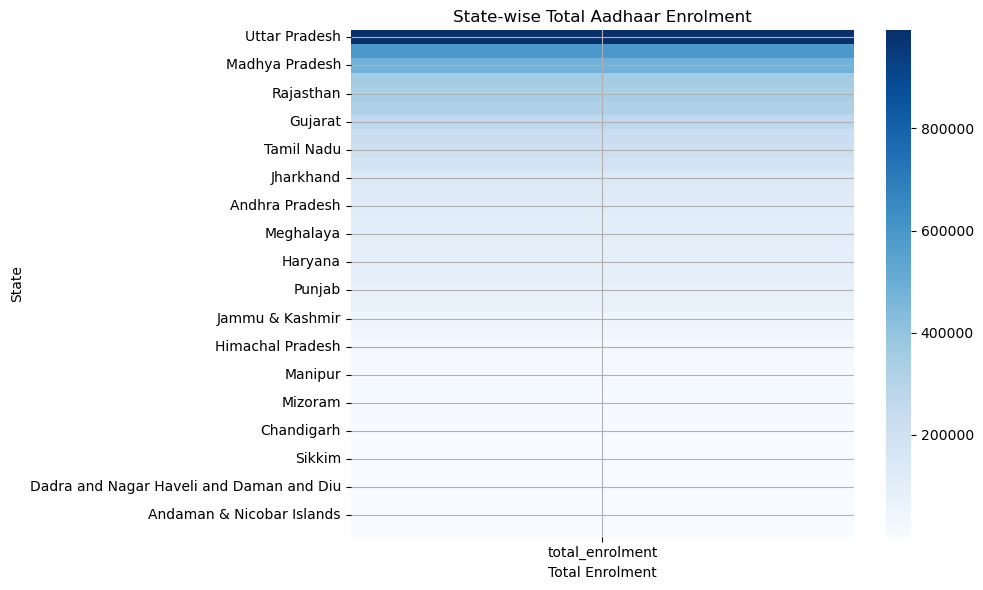

Heatmap saved as: heatmap_state_total_enrolment_heatmap.png


In [16]:

# -------------------------------------------
# CREATE TOTAL ENROLMENT COLUMN (IF NOT THERE)
# -------------------------------------------
enrol_df['total_enrolment'] = (
    enrol_df['age_0_5'] +
    enrol_df['age_5_17'] +
    enrol_df['age_18_greater']
)

# -------------------------------------------
# AGGREGATE BY STATE
# -------------------------------------------
state_enrol = (
    enrol_df.groupby('state')['total_enrolment']
    .sum()
    .reset_index()
)

# Sort for better visual
state_enrol = state_enrol.sort_values(by='total_enrolment', ascending=False)

# -------------------------------------------
# CREATE HEATMAP
# -------------------------------------------
plt.figure(figsize=(10,6))

sns.heatmap(
    state_enrol.set_index('state'),
    cmap="Blues",
    annot=False
)

plt.title("State-wise Total Aadhaar Enrolment")
plt.xlabel("Total Enrolment")
plt.ylabel("State")
plt.tight_layout()

# Save image
plt.savefig("heatmap_state_total_enrolment_heatmap.png")
plt.grid(True)
plt.show()

print("Heatmap saved as: heatmap_state_total_enrolment_heatmap.png")
